In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Final_Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)

Looking at the total number of failures for each 

In [2]:
wq_df.sum().iloc[33:41]

Top Ammonium (mg/L) Failure                                                             147
Top Active Chlorophyll 'A' (µg/L) Failure                                              3628
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure    1764
Top Enterococci Bacteria (Cells/100mL) Failure                                         2186
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                      1291
Top Total Kjeldhal Nitrogen (mg/L) Failure                                               11
Top PH Failure                                                                            7
Top Ortho-Phosphorus (mg/L) Failure                                                    1814
dtype: object

Next I create graphs using the average value of the failure column to alter the size of each marker. I used averages to control for differences in sampling frequency.

In [3]:
site_fail_df = wq_df.groupby('Sampling Location').mean().iloc[:, 28:39].drop(columns='Weather Condition (Dry or Wet)_W')

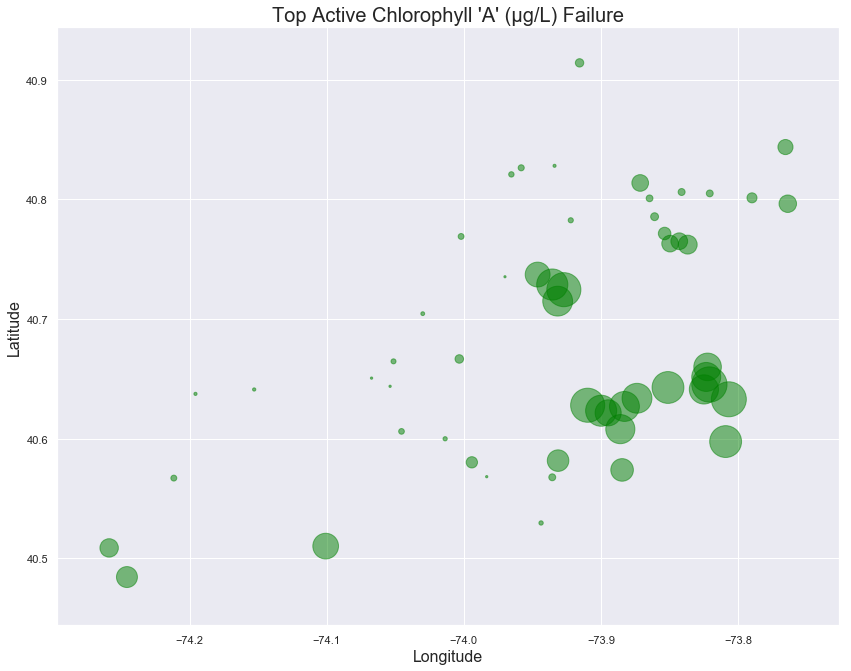

In [4]:
_ = plt.figure(figsize=(14, 11))
_ = plt.scatter(x=site_fail_df['Long'], y=site_fail_df['Lat'], 
                alpha=.5, c='green',
                s=site_fail_df['Top Active Chlorophyll \'A\' (µg/L) Failure']*2500)
_ = plt.title('Top Active Chlorophyll \'A\' (µg/L) Failure', fontsize=20)
_ = plt.xlabel('Longitude', fontsize=16)
_ = plt.ylabel('Latitude', fontsize=16)

# want to add labels to top 5 sites

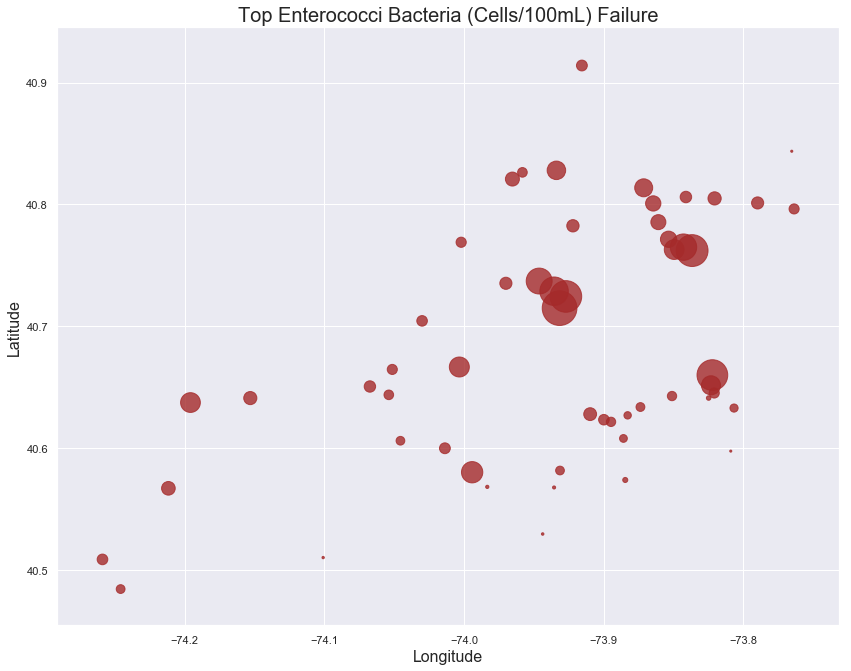

In [5]:
_ = plt.figure(figsize=(14, 11))
_ = plt.scatter(x=site_fail_df['Long'], y=site_fail_df['Lat'], 
                alpha=.8, c='brown',
                s=site_fail_df['Top Enterococci Bacteria (Cells/100mL) Failure']*2500)
_ = plt.title('Top Enterococci Bacteria (Cells/100mL) Failure', fontsize=20)
_ = plt.xlabel('Longitude', fontsize=16)
_ = plt.ylabel('Latitude', fontsize=16)

# want to add labels to top 5 sites

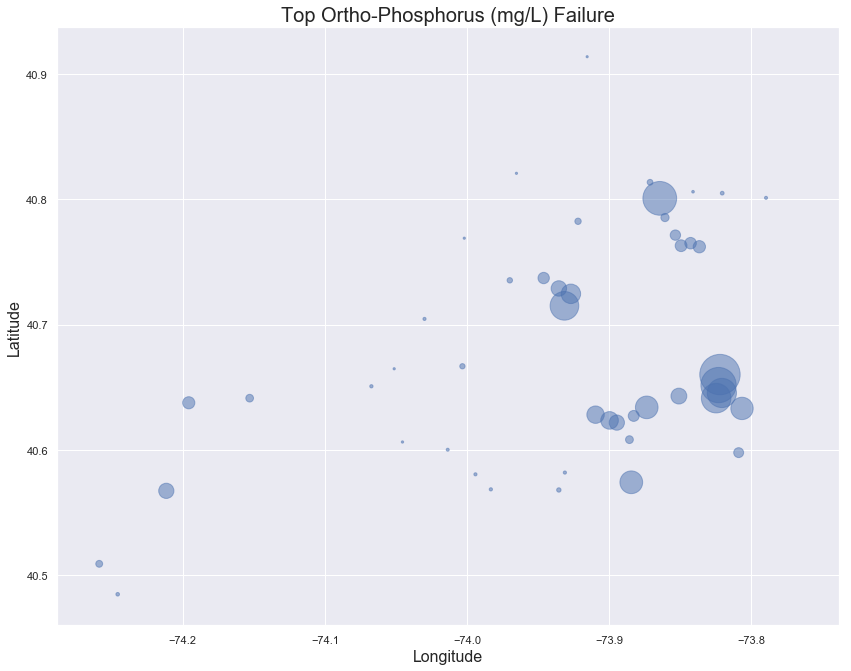

In [6]:
_ = plt.figure(figsize=(14, 11))
_ = plt.scatter(x=site_fail_df['Long'], y=site_fail_df['Lat'], 
                alpha=.5,
                s=site_fail_df['Top Ortho-Phosphorus (mg/L) Failure']*2500)
_ = plt.title('Top Ortho-Phosphorus (mg/L) Failure', fontsize=20)
_ = plt.xlabel('Longitude', fontsize=16)
_ = plt.ylabel('Latitude', fontsize=16)

# want to add labels to top 5 sites

In order to understand the relationships between different sites and their water quality, I need to build a network to perform analysis with. I started by writing a function to build the network, and then from there I apply it my three target columns.

In [7]:
def create_wq_network(df, fail_col):
    '''Takes a dataframe and creates a network out of the 
       different sites within based on fail_col.'''
    G = nx.MultiGraph()
    fail_col_df = df[df[fail_col] == 1]
    fail_col_df = fail_col_df.reset_index(drop=True)


    for i, row in tqdm(fail_col_df.iterrows()):
        # Sample Date is at index 2
        month = row['Sample Date'].month
        year = row['Sample Date'].year
        for row2 in fail_col_df.drop(index=i).itertuples():
            if row2[2].month == month and row2[2].year == year:
                # Sampling Location is at index 1
                G.add_edge(row['Sampling Location'], row2[1],
                               #dates=(row['Sampling Location'], row2[2])
                              )
    return G

In [8]:
chlG = create_wq_network(wq_df, 'Top Active Chlorophyll \'A\' (µg/L) Failure')

3628it [02:44, 22.01it/s]


C:\Users\Drew\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


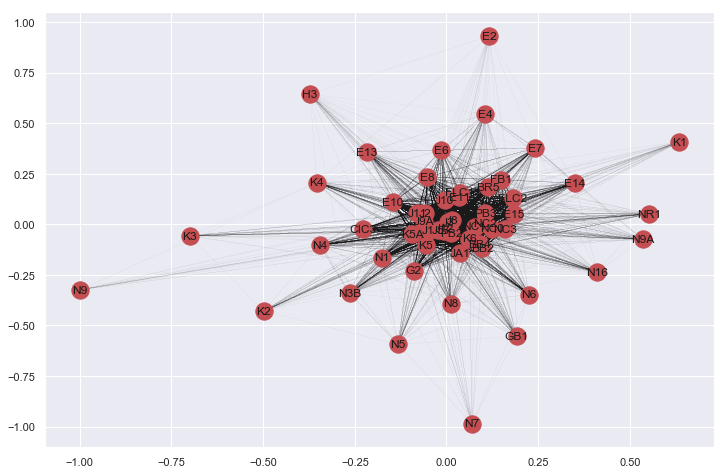

In [ ]:
_ = plt.figure(figsize=(12,8))
_ = nx.drawing.nx_pylab.draw_networkx(chlG, width=0.01)
_ = plt.show()

In [ ]:
sorted_centrality_c = sorted(nx.degree_centrality(chlG).items(), key = lambda x : x[1], reverse=True)
sorted_centrality_c[:15]

[('NC1', 361.59259259259255),
 ('J12', 337.3703703703703),
 ('J7', 320.8148148148148),
 ('NC2', 286.9259259259259),
 ('J8', 272.1111111111111),
 ('J5', 264.0),
 ('J3', 247.7037037037037),
 ('NC0', 237.48148148148147),
 ('J9A', 208.44444444444443),
 ('NC3', 197.8148148148148),
 ('J2', 191.25925925925924),
 ('PB2', 189.8148148148148),
 ('PB3', 153.07407407407408),
 ('K6', 144.74074074074073),
 ('J11', 123.29629629629629)]

In [ ]:
entG = create_wq_network(wq_df, 'Top Enterococci Bacteria (Cells/100mL) Failure')

186it [00:05, 38.15it/s]

In [ ]:
_ = plt.figure(figsize=(12,8))
_ = nx.drawing.nx_pylab.draw_networkx(entG, width=0.01)
_ = plt.show()

In [ ]:
sorted_centrality_e = sorted(nx.degree_centrality(entG).items(), key = lambda x : x[1], reverse=True)
sorted_centrality_e[:15]

In [ ]:
phoG = create_wq_network(wq_df, 'Top Ortho-Phosphorus (mg/L) Failure')

In [ ]:
_ = plt.figure(figsize=(12,8))
_ = nx.drawing.nx_pylab.draw_networkx(phoG, width=0.01)
_ = plt.show()

In [ ]:
sorted_centrality_p = sorted(nx.degree_centrality(phoG).items(), key = lambda x : x[1], reverse=True)
sorted_centrality_p[:15]

There are some sites that are highly central for all three 

In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

int_df = wq_df.select_dtypes(include=[float, 'int64'])
int_df = int_df.drop(columns=['Lat', 'Long', 'Top Active Chlorophyll \'A\' (µg/L)'])
features = int_df.loc[:, int_df.columns != 'Top Active Chlorophyll \'A\' (µg/L) Failure']
target = int_df.loc[:, 'Top Active Chlorophyll \'A\' (µg/L) Failure']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=13, 
                                                stratify=target)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


skb = SelectKBest(mutual_info_classif, k=features.shape[1])
skb.fit(Xtrain, ytrain)
mask = skb.get_support()
kbestfeat = list()

for boolean, feature in zip(mask, int_df.columns):
    if boolean:
        kbestfeat.append(feature)

indices = np.argsort(skb.scores_)[::-1]
cols = []
for i in range(36):
    cols.append(int_df.columns[indices[i]])

# Now plot
_ = plt.figure(figsize=[12,7])
_ = plt.bar(cols, skb.scores_[indices[range(36)]], color='g', align='center')
_ = plt.xticks(rotation=90)
_ = plt.title('Best Descriptors of Chlorophyll Based on Mutual Information Score', size=20)
_ = plt.xlabel('Feature')
_ = plt.ylabel('Mutual Information')
_ = plt.show()

In [ ]:
int_df = wq_df.select_dtypes(include=[float, 'int64'])
int_df = int_df.drop(columns=['Lat', 'Long', 'Top Enterococci Bacteria (Cells/100mL)'])
features = int_df.loc[:, int_df.columns != 'Top Enterococci Bacteria (Cells/100mL) Failure']
target = int_df.loc[:, 'Top Enterococci Bacteria (Cells/100mL) Failure']
print(features.columns)
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=13, 
                                                stratify=target)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


skb = SelectKBest(mutual_info_classif, k=features.shape[1])
skb.fit(Xtrain, ytrain)
mask = skb.get_support()
kbestfeat = list()

for boolean, feature in zip(mask, int_df.columns):
    if boolean:
        kbestfeat.append(feature)

indices = np.argsort(skb.scores_)[::-1]
cols = []
for i in range(36):
    cols.append(int_df.columns[indices[i]])

# Now plot
_ = plt.figure(figsize=[12,7])
_ = plt.bar(cols, skb.scores_[indices[range(36)]], color='r', align='center')
_ = plt.xticks(rotation=90)
_ = plt.title('Best Descriptors of Enterococci Based on Mutual Information Score', size=20)
_ = plt.xlabel('Feature')
_ = plt.ylabel('Mutual Information')
_ = plt.show()

In [ ]:
int_df = wq_df.select_dtypes(include=[float, 'int64'])
int_df = int_df.drop(columns=['Lat', 'Long', 'Top Ortho-Phosphorus (mg/L)'])
features = int_df.loc[:, int_df.columns != 'Top Ortho-Phosphorus (mg/L) Failure']
target = int_df.loc[:, 'Top Ortho-Phosphorus (mg/L) Failure']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=13, 
                                                stratify=target)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


skb = SelectKBest(mutual_info_classif, k=features.shape[1])
skb.fit(Xtrain, ytrain)
mask = skb.get_support()
kbestfeat = list()

for boolean, feature in zip(mask, int_df.columns):
    if boolean:
        kbestfeat.append(feature)

indices = np.argsort(skb.scores_)[::-1]
cols = []
for i in range(36):
    cols.append(int_df.columns[indices[i]])

# Now plot
_ = plt.figure(figsize=[12,7])
_ = plt.bar(cols, skb.scores_[indices[range(36)]], color='b', align='center')
_ = plt.xticks(rotation=90)
_ = plt.title('Best Descriptors of Ortho-Phosphorus Based on Mutual Information Score', size=20)
_ = plt.xlabel('Feature')
_ = plt.ylabel('Mutual Information')
_ = plt.show()

I am going to perform a naive bayes classification on ortho-phosphorus. First I need to balance my dataset

In [ ]:
def balance(df, param):
    '''Upsamples dataset to balance target variable categorizations.'''
    
    target = param + ' Failure'
    int_df = df.select_dtypes(include=[float, 'int64'])
    int_df = int_df.drop(columns=['Lat', 'Long', param])
    
    class0 = int_df[int_df[target] == 0]
    class1 = int_df[int_df[target] == 1]
    nclass0 = len(class0)
    nclass1 = len(class1)
    class1_upsampled = np.random.choice(class1.index, size=nclass0, replace=True)
    upsampled_int_df = class0.append(int_df.iloc[class1_upsampled])
    
    return upsampled_int_df


In [ ]:
# Upsample dataset to balance it
balance_df_pho = balance(wq_df, 'Top Ortho-Phosphorus (mg/L)')

# Split data into features and target variable (Top Ortho-Phosphorus)
features = balance_df_pho.loc[:, balance_df_pho.columns != 'Top Ortho-Phosphorus (mg/L) Failure']
target = balance_df_pho.loc[:, 'Top Ortho-Phosphorus (mg/L) Failure']

# Split data into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=13)

# Fit Naive Bayes classifier to split data
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(Xtrain, ytrain)

y_pred = gnb.predict(Xtest)

In [ ]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(ytest, y_pred))

In [ ]:
# Upsample dataset to balance it
balance_df_ent = balance(wq_df, 'Top Enterococci Bacteria (Cells/100mL)')

# Split data into features and target variable (Top Enterococci)
features = balance_df_ent.loc[:, balance_df_ent.columns != 'Top Enterococci Bacteria (Cells/100mL) Failure']
target = balance_df_ent.loc[:, 'Top Enterococci Bacteria (Cells/100mL) Failure']

# Split data into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=13)

# Fit Naive Bayes classifier to split data
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(Xtrain, ytrain)

y_pred = gnb.predict(Xtest)

In [ ]:
print("Accuracy:", metrics.accuracy_score(ytest, y_pred))

In [ ]:
# Upsample dataset to balance it
balance_df_chl = balance(wq_df, "Top Active Chlorophyll 'A' (µg/L)")

# Split data into features and target variable (Top Active Chlorophyll A)
features = balance_df_chl.loc[:, balance_df_chl.columns != "Top Active Chlorophyll 'A' (µg/L) Failure"]
target = balance_df_chl.loc[:, "Top Active Chlorophyll 'A' (µg/L) Failure"]

# Split data into training and test
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=13)

# Fit Naive Bayes classifier to split data
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(Xtrain, ytrain)

y_pred = gnb.predict(Xtest)

In [ ]:
print("Accuracy:", metrics.accuracy_score(ytest, y_pred))

All three of these variables are predicted with ~75% accuracy.

I want to cluster the different sampling sites. This information in conjunction with the list of highly connected sites may help me identify which sites may have the best predictive qualities. I am going to use a dataframe similar to the `site_fail_df` from earlier to perform this.

In [ ]:
cluster_df = wq_df.groupby('Sampling Location').mean().drop(columns=['Month', 'Lat', 'Long'])

The original dataset has the sites broken up by 12 geographically based groups as illustrated by the letter at the beginning of each site name. My first question is will the clustering algorithm group them into the "correct" groups? To do so, I use K-Means clustering algorithm

In [ ]:
from sklearn.cluster import KMeans
kmeansModel = KMeans(n_clusters=12).fit(cluster_df)
cluster_df['cluster'] = kmeansModel.labels_
cluster_df[['cluster']].sort_values('cluster')

While some clusters are similar to the geographical designation, decidedly this is not an accurate description of the within site differences. I will now perform clustering and estimate how many clusters make sense for my dataset.

In [ ]:
# clustering dataset
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# create new plot and data
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(cluster_df)
    kmeanModel.fit(cluster_df)
    distortions.append(sum(np.min(cdist(cluster_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cluster_df.shape[0])

# Plot the elbow
plt.figure(figsize=(12,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the graph above, my datset should be split up into 3 distinct groups. This point is the "elbow" of the graph signaling that this amount should give a good estimate of the different clusters without overfitting to my datset

In [ ]:
cluster_df = wq_df.groupby('Sampling Location').mean().drop(columns=['Month', 'Lat', 'Long'])
kmeans = KMeans(n_clusters=3).fit(cluster_df)
cluster_df = wq_df.groupby('Sampling Location').mean().drop(columns=['Month'])
cluster_df['cluster'] = kmeans.labels_

In [ ]:
_ = plt.figure(figsize=(14, 11))
_ = sns.scatterplot(x='Long', y='Lat', hue='cluster', data=cluster_df,
               palette=['g', 'b', 'r'], s=100, alpha= .5) 
_ = plt.title('Cluster Visualization', fontsize=20)
_ = plt.xlabel('Longitude', fontsize=16)
_ = plt.ylabel('Latitude', fontsize=16)